# Tracking con ML Flow

## Importacion de la data

In [9]:
import pandas as pd
import numpy as np
df_news=pd.read_csv("../Datos/noticias_bitcoin_sentimientos.csv")
df_btc=pd.read_csv("../Datos/BTC_USD_Media_Movil.csv")
df_btc['Date']=pd.to_datetime(df_btc['Date'], format='%Y-%m-%d')
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1096 non-null   datetime64[ns]
 1   Close      1096 non-null   float64       
 2   High       1096 non-null   float64       
 3   Low        1096 non-null   float64       
 4   Open       1096 non-null   float64       
 5   Volume     1096 non-null   float64       
 6   Close_7d   1090 non-null   float64       
 7   Volume_7d  1090 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 68.7 KB


In [10]:
df_news['fecha'] = pd.to_datetime(df_news['fecha'], format='%Y-%m-%d')

df_news_avg_score = df_news.groupby('fecha')['score'].mean().reset_index()

In [11]:
df_model=df_btc[['Date','Close']]
df_model = pd.merge(df_model, df_news_avg_score, how='left', left_on='Date', right_on='fecha')
df_model.fillna(0, inplace=True)
df_model.drop(columns=['fecha'], inplace=True)
df_model['Date'] = pd.to_datetime(df_model['Date'])

C:\Users\equipo\AppData\Local\Temp\ipykernel_13768\1242759099.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_model.fillna(0, inplace=True)


## XGBoost parametros

In [2]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.6/150.0 MB 5.6 MB/s eta 0:00:27
    --------------------------------------- 2.1/150.0 MB 5.3 MB/s eta 0:00:28
    --------------------------------------- 2.9/150.0 MB 4.1 MB/s eta 0:00:36
    --------------------------------------- 3.1/150.0 MB 4.3 MB/s eta 0:00:35
    --------------------------------------- 3.4/150.0 MB 3.6 MB/s eta 0:00:41
   - -------------------------------------- 3.9/150.0 MB 3.1 MB/s eta 0:00:48
   - -------------------------------------- 5.2/150.0 MB 3.4 MB/s eta 0:00:43
   - -------------------------------------- 6.6/150.0 MB 3.8 MB/s eta 0:00:39
   -- ------------------------------------- 8.4/150.0 MB 4.3 MB/s eta 0:00:33
   -- ------------------------------------- 9.7/150.0 MB 4.5 MB/s eta 0:00:32
   -- ------------------------------------- 11.0/150.0 MB 4.7 MB/s eta 0:00:30

MAE: 2366.94
RMSE: 3257.83


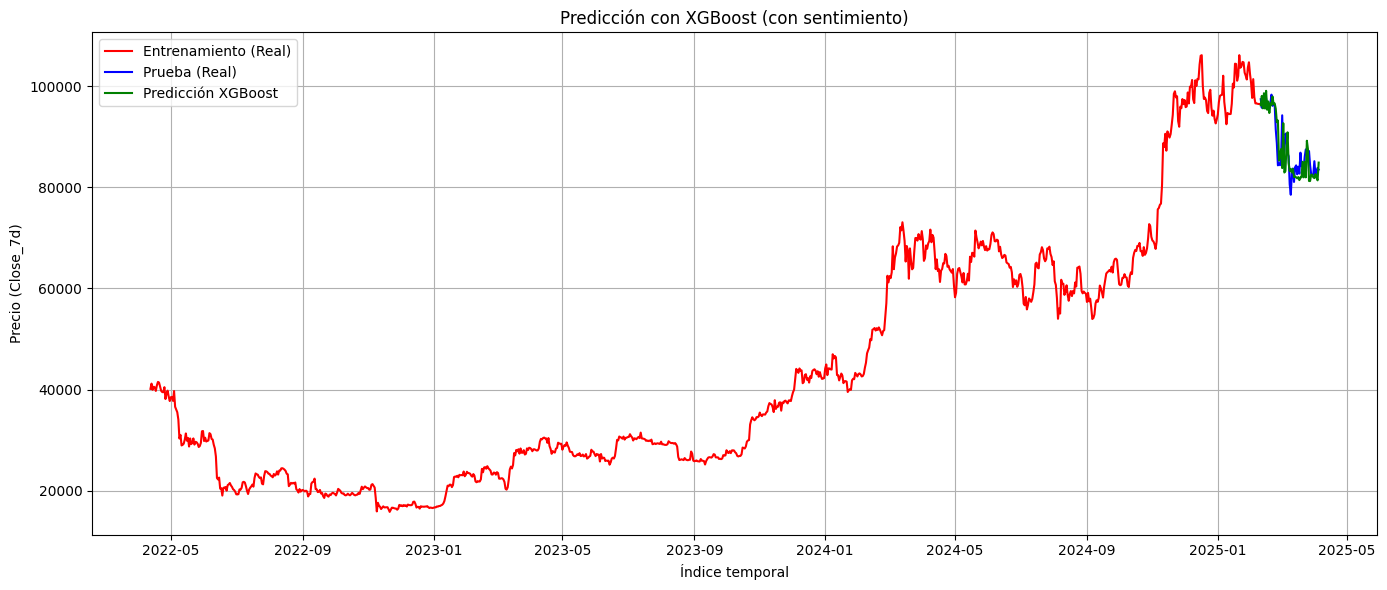

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Crear variables rezagadas (lags)
def crear_lags(data, target_col, n_lags):
    df = data.copy()
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df.dropna()

# Supón que tienes un DataFrame llamado df con una columna 'Close_7d'
# Reemplaza esto si tu DataFrame se llama distinto
n_lags = 7
df_lags = crear_lags(df_model, 'Close', n_lags)
# 2. Separar en conjunto de entrenamiento y prueba (80/20)
train_size = int(len(df_lags) * 0.95)
train = df_lags.iloc[:train_size]
test = df_lags.iloc[train_size:]

X_train = train.drop(columns=['Close', 'Date'])
y_train = train['Close']
X_test = test.drop(columns=['Close', 'Date'])
y_test = test['Close']

# 3. Entrenar el modelo XGBoost
model_sent = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

model_sent.fit(X_train, y_train)

# 4. Predicciones
y_pred = model_sent.predict(X_test)

# 5. Evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(14, 6))

# Graficar entrenamiento en rojo
plt.plot(df_btc['Date'][y_train.index], y_train.values, label='Entrenamiento (Real)', color='red')

# Graficar prueba real en azul
plt.plot(df_btc['Date'][y_test.index], y_test.values, label='Prueba (Real)', color='blue')

# Graficar predicción en verde punteado
plt.plot(df_btc['Date'][y_test.index], y_pred, label='Predicción XGBoost', color='green')

# Estética
plt.title('Predicción con XGBoost (con sentimiento)')
plt.xlabel('Índice temporal')
plt.ylabel('Precio (Close_7d)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [19]:
df_model = df_model.drop(index=df_model.index[0])

MAE (datos históricos): 389.76195907943065
RMSE (datos históricos): 549.1250438847816


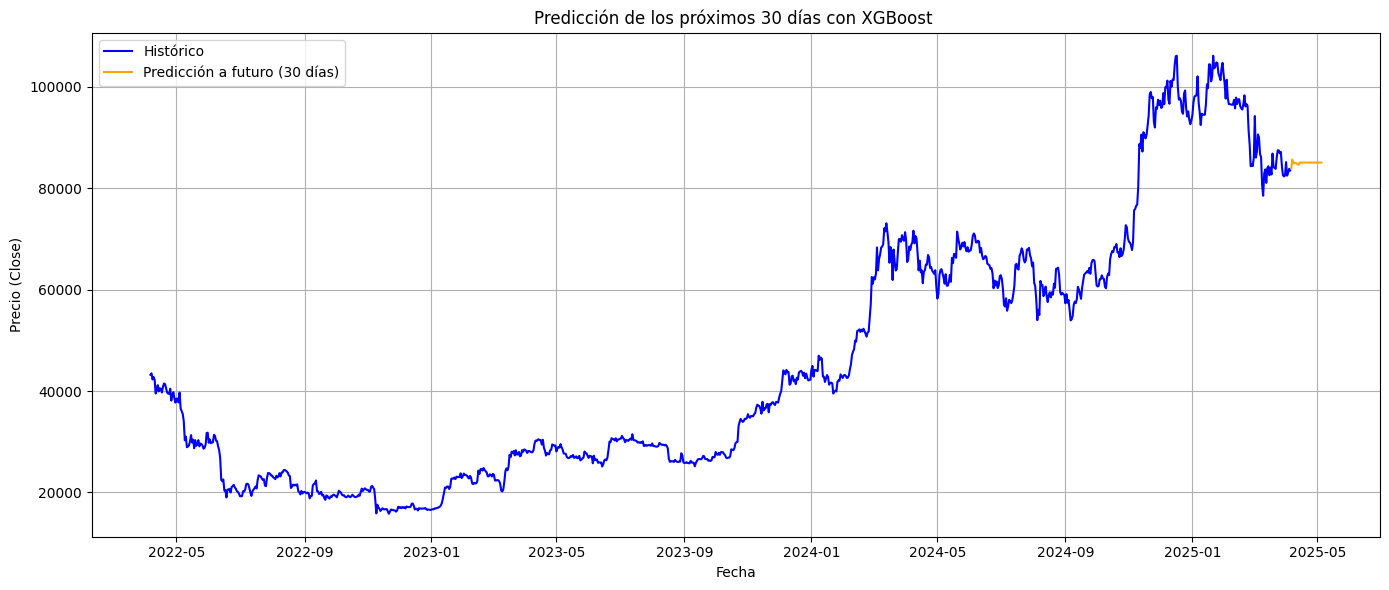

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Función para crear variables rezagadas (lags)
def crear_lags(data, target_col, n_lags):
    df = data.copy()
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df.dropna()

# Configuración: número de lags a usar
n_lags = 7

# 2. Crear dataset de entrenamiento a partir de df_model
df_lags = crear_lags(df_model, 'Close', n_lags)
# Se asume que df_model también tiene la columna 'Date'

# Aquí usamos todos los datos disponibles para el entrenamiento
X_all = df_lags.drop(columns=['Close', 'Date'])
y_all = df_lags['Close']

# 3. Entrenar el modelo XGBoost con todos los datos
model_sent = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

model_sent.fit(X_all, y_all)

# (Opcional) Si deseas evaluar en datos históricos, puedes predecir sobre X_all
y_pred_all = model_sent.predict(X_all)
print("MAE (datos históricos):", mean_absolute_error(y_all, y_pred_all))
print("RMSE (datos históricos):", np.sqrt(mean_squared_error(y_all, y_pred_all)))


# 4. Función para predecir futuros de forma recursiva
def forecast_future(model, X_last, n_forecast):
    """
    model: modelo entrenado
    X_last: DataFrame con los features (lags) utilizado para entrenar;
            se usa la última fila para iniciar la predicción recursiva.
    n_forecast: número de pasos a predecir (p.ej. 30 días)
    """
    # Tomamos la última fila como base para la predicción
    current_input = X_last.values[-1].reshape(1, -1)
    forecasts = []
    for _ in range(n_forecast):
        # Predecir el siguiente valor
        pred = model.predict(current_input)[0]
        forecasts.append(pred)
        # Actualizamos los lags: desplazamos a la izquierda (roll) y ponemos la predicción al final
        new_input = np.roll(current_input, shift=-1, axis=1)
        new_input[0, -1] = pred
        current_input = new_input
    return forecasts

# Predecir los próximos 30 días
n_forecasts = 30
future_preds = forecast_future(model_sent, X_all, n_forecasts)

# 5. Preparar la serie de fechas futuras a partir de la última fecha de df_model
ultima_fecha = pd.to_datetime(df_model['Date'].max())
future_dates = pd.date_range(start=ultima_fecha + pd.Timedelta(days=1), periods=n_forecasts, freq='D')

# 6. Visualización
plt.figure(figsize=(14, 6))

# Graficar datos históricos completos
plt.plot(pd.to_datetime(df_model['Date']), df_model['Close'], label='Histórico', color='blue')

# Graficar las predicciones futuras
plt.plot(future_dates, future_preds, label='Predicción a futuro (30 días)', color='orange')

plt.title('Predicción de los próximos 30 días con XGBoost ')
plt.xlabel('Fecha')
plt.ylabel('Precio (Close)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
